## 理论介绍

风险平价投资组合是一种资产配置，其重点是**配置风险**，而不是配置资产。例如，典型的债券40％、股票60％投资组合中，股票风险很大。风险平价（等同风险）是这样一种投资组合：**单个资产（在这种情况下为债券和股票）对整体投资组合总风险具有相同的风险贡献**。该理论在过去几十年中得到普及和发展，基于风险的资产配置理念已被用于许多策略，如管理期货策略和着名的桥水全天候基金。有研究表明，这种资产配置策略比基于资产的配置策略提供更好的风险调整回报。 

In [ ]:
我将讨论风险平价的一个非常基本的例子，以及如何构建简单的风险平价（相等风险）投资组合，并将其扩展到风险预算组合（目标风险分配）的具体实现。

In [ ]:
首先将资产j的**边际风险贡献（$MRC_j$）**定义为：

$$MRC_j = \frac{\partial \sigma_p}{\partial w_j} = \frac{(V*w)_j}{\sigma_p}$$

其中：

$w_j$表示第j个资产的权重

$V$表示资产的协方差矩阵

$\sigma_p = \sqrt{w*V*w^T}$ 表示组合风险

In [ ]:
然后，资产j对总投资组合的**风险贡献($RC_j$)**为：

In [ ]:
$$RC_j = w*MRC_j = \frac{{w_j(V*w)}_j}{\sigma_p}$$

In [ ]:
风险平价投资组合是所有资产中每个资产的$RC$相等的投资组合。

In [ ]:
计算风险平价组合的权重，本质上属于一个**二次优化**问题。

让投资组合资产$RC$的平方误差的总和为(优化问题的目标函数)：

In [ ]:
$$J(x)=(\sum_{i=1}^n\sum_{j=1}^n(w_i(V*w))_i-w_j(V*w)_j)^2$$

In [ ]:
优化问题的约束条件为：

$$minJ(x)$$

$$s.t.\sum_iw_i = 1 $$  

$$1 \geq wi \geq 0$$

## 代码实现

- 假设组合有四项资产
- 资产收益率为$R$
- 资产协方差为$V$

In [15]:
# 协方差矩阵和收益率向量
from scipy.optimize import minimize
V = V
R = mu # return

In [16]:
 # 风险预算优化
def calculate_portfolio_var(w,V):
    # 计算组合风险的函数
    w = np.matrix(w)
    return (w*V*w.T)[0,0]

def calculate_risk_contribution(w,V):
    # 计算单个资产对总体风险贡献度的函数
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # 边际风险贡献
    MRC = V*w.T
    # 风险贡献
    RC = np.multiply(MRC,w.T)/sigma
    return RC

def risk_budget_objective(x,pars):
    # 计算组合风险
    V = pars[0]# 协方差矩阵
    x_t = pars[1] # 组合中资产预期风险贡献度的目标向量
    sig_p =  np.sqrt(calculate_portfolio_var(x,V)) # portfolio sigma
    risk_target = np.asmatrix(np.multiply(sig_p,x_t))
    asset_RC = calculate_risk_contribution(x,V)
    J = sum(np.square(asset_RC-risk_target.T))[0,0] # sum of squared error
    return J

def total_weight_constraint(x):
    return np.sum(x)-1.0

def long_only_constraint(x):
    return x


In [21]:
# 根据资产预期目标风险贡献度来计算各资产的权重
def calcu_w(x):
    w0 = [0.2, 0.2, 0.2] 
#     x_t = [0.25, 0.25, 0.25, 0.25] # 目标是让四个资产风险贡献度相等，即都为25%
    x_t = x 
    cons = ({'type': 'eq', 'fun': total_weight_constraint},
    {'type': 'ineq', 'fun': long_only_constraint})
    res= minimize(risk_budget_objective, w0, args=[V,x_t], method='SLSQP',constraints=cons, options={'disp': True})
    w_rb = np.asmatrix(res.x)
    return w_rb

In [24]:
# 将各资产风险贡献度绘制成柱状图
def plot_rc(w):
    rc = calculate_risk_contribution(w, V)
    rc = rc.tolist()
    rc = [i[0] for i in rc]
    rc = pd.DataFrame(rc,columns=['rick contribution'],index=[1,2,3])
    T.plot(rc, chart_type='column', title = 'Contribution to risk')
    

In [25]:
# 假设四个资产的风险贡献度相等
w_rb = calcu_w([0.25, 0.25, 0.25])
print('各资产权重：', w_rb)
plot_rc(w_rb)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0001314586611012819
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 5
各资产权重： [[0.33679511 0.38700389 0.27620101]]


In [26]:
# 假设风险贡献度依次为0.3,0.3,0.1,0.3
w = calcu_w([0.3, 0.3 ,0.1,0.3])
print('各资产权重：', w)
plot_rc(w)

ValueError: operands could not be broadcast together with shapes (3,1) (4,1) 

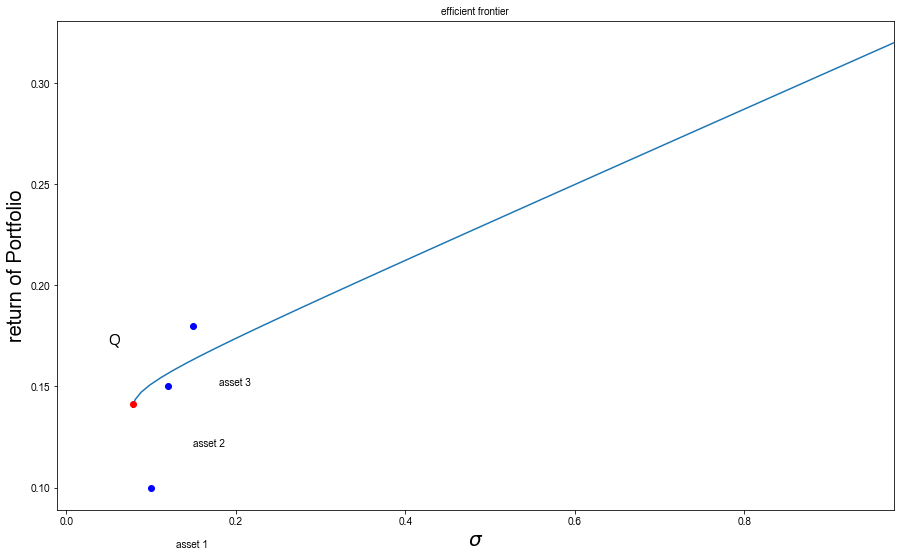

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

rf = 0.05                 # 无风险利率
mu = np.array([0.1,0.15,0.18]) # 预期收益率向量
sigma = np.array([0.1,0.12,0.15])
rou_ab, rou_ac, rou_bc = 0.2, 0.5, -0.2
# 协方差矩阵
C = np.array([[1,      rou_ab,  rou_ac],
              [rou_ab, 1,       rou_bc],
              [rou_ac, rou_bc,  1     ]])
V = np.outer(sigma,sigma)*C

# 前沿曲线绘图函数
def plot_efficient_frontier(rf=rf,mu=mu,V=V,is_subplot=False,show_E=False,strategy=None):
    f = mu-rf                 # 超额收益
    N = len(mu)
    e = np.ones(N)
    sigma = np.sqrt(np.diag(V))
    V_inverse = np.linalg.inv(V)
    # 等权投资组合
    w_E = e/N
    sigma2_E = w_E.dot(V).dot(w_E)
    sigma_E = np.sqrt(sigma2_E)
    f_E = w_E.dot(f)
    # 最小方差组合
    w_C = V_inverse.dot(e)/e.T.dot(V_inverse).dot(e)
    sigma2_C = w_C.dot(V).dot(w_C)
    sigma_C = np.sqrt(sigma2_C)
    f_C = w_C.dot(f)
    # 夏普组合
    w_Q = np.array([0.33679511,0.38700389,0.27620101])

    sigma2_Q = w_Q.dot(V).dot(w_Q)
    sigma_Q = np.sqrt(sigma2_Q)
    f_Q = w_Q.dot(f)
    
    # 有效前沿曲线
    f_P = np.linspace(f_C,1.5*np.max(mu)) # 只取上半部分抛物线
    get_w_P = lambda fp: (f_Q-fp)/(f_Q-f_C)*w_C + (fp-f_C)/(f_Q-f_C)*w_Q
    w_P = np.array([get_w_P(fp) for fp in f_P])
    k = (sigma2_Q-sigma2_C)/(f_Q-f_C)**2
    sigma2_P = sigma2_C + k*(f_P-f_C)**2
    sigma_P = np.sqrt(sigma2_P)
    r_P = rf + w_P.dot(f)
    # 策略组合
    if strategy is not None:
        w_S,f_S,sigma_S = strategy(pred_ret,V)
    # 资本市场曲线CML
    # s = np.linspace(0,0.2)
    # CML = rf + f_Q/sigma_Q * s
    # 有效前沿曲线绘制
    plt.plot(sigma_P,r_P)
#     plt.title('efficient frontier',fontsize=20)
    plt.title('efficient frontier',fontsize=10)
    plt.xlabel('$\sigma$',fontsize=20)
    plt.ylabel('return of Portfolio',fontsize=20)
    x_axis_low, x_axis_high = sigma_C-(sigma_P.max()-sigma_C)*0.1,sigma_P.max()
    plt.xlim(x_axis_low, x_axis_high)
    # 绘制风险资产
    plt.plot(sigma,mu,'bo')
    x_axis_length = x_axis_high-x_axis_low
    text_margin_space = x_axis_length*0.03
    for i in range(N):
        plt.text(sigma[i]+text_margin_space,mu[i]-text_margin_space,'asset '+str(i+1),fontsize=10)


    plt.plot(sigma_Q, rf+f_Q,'ro')
    plt.text(sigma_Q-text_margin_space,rf+f_Q+text_margin_space,'Q',fontsize=15)
#    plt.plot(0, rf,'yo')
#    plt.text(0-0.005,rf+0.008,'$r_{f}$',fontsize=15)
    # 绘制CML
    # plt.plot(s, CML, 'r-')
    # plt.text(0.15,0.28,'CML',fontsize=15)
    if not is_subplot:
        plt.show()
plt.figure(figsize=(15,9))
plot_efficient_frontier(show_E=True)